#### keras数据读取

Keras是一个高层神经网络API，keras由纯Python编写而成并基于Tensorflow、Theano、CNTK后端。Keras为支持快速试验而生，它的特点如下：
- 简易，快速的原型设计（高度模块化，极简，可扩充）
- 支持CNN和RNN，或者两者的结合
- 无缝CPU和GPU切换

keras设计原则：
+ 用户友好
+ 模块化
+ 易扩展性
+ 与python协作

keras中有一个图像预处理类ImageDataGenerator，用以生成一个batch的图像数据，支持实时数据增强。训练时该函数会无限生成数据，直到达到规定的epoch次数为止

In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
import warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'

ImageDataGenerator的参数如下: 

- rotation_range，整数，数据提升时图片随机转动的角度
- width_shift_range，浮点数，图片宽度的某个比例，数据提升时图片水平偏移的幅度
- height_shift_range，浮点数，图片高度的某个比例，数据提升时图片竖直偏移的幅度
- shear_range，浮点数，剪切强度（逆时针方向的剪切变换角度）
- zoom_range，浮点数或形如[lower,upper]的列表，随机缩放的幅度，若为浮点数，则相当于[lower,upper] = [1 - zoom_range, 1+zoom_range]
- horizontal_flip，布尔值，进行随机水平翻转
- vertical_flip，布尔值，进行随机竖直翻转
- fill_mode，‘constant’，‘nearest’，‘reflect’或‘wrap’之一，当进行变换时超出边界的点将根据本参数给定的方法进行处理

In [5]:
data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     vertical_flip=True,
                     horizontal_flip=True,
                     fill_mode='nearest')

ImageDataGenerator包含了一个flow_from_directory方法，该方法以文件夹路径为参数，生成经过数据提升后的数据，在一个无限循环中无限产生batch数据。

该方法参数如下：

- directory，目标文件夹路径，对于每一个类，该文件夹都要包含一个子文件夹。子文件夹中任何jpg，png，bnp的图片都会被生成器使用
- target_size，整数tuple,默认为(256, 256). 图像将被resize成该尺寸
- color_mode，颜色模式，为‘grayscale’，‘rgb’之一
- classes，可选参数，为子文件夹的列表，如['dogs','cats']
- class_mode，"categorical", "binary", "sparse"或None之一. 默认为"categorical. 该参数决定了返回的标签数组的形式, "categorical"会返回2D的one-hot编码标签,"binary"返回1D的二值标签."sparse"返回1D的整数标签,如果为None则不返回任何标签
- batch_size，batch数据的大小，默认32
- shuffle，是否打乱数据,默认为True
- seed，可选参数,打乱数据和进行变换时的随机数种子

这里使用的数据集是CamVid数据集。包含训练数据，验证数据和测试数据。训练数据是一张张png图片，保存在`test`文件夹中，图片是三通道rgb模式。每张图片包含12个语义分割类别。标签数据保存在`trainannot`文件夹下，也是3通道的png图片，因为有12个类别，因此标签图片的像素值为0-11，代表着对应训练图片中该位置的像素属于对应12类中的某一类。

In [46]:
train_path = '/dataset/CamVid'
image_folder = 'train'
label_folder = 'trainannot'
num_class = 12
image_color_mode = 'rgb'
label_color_mode = 'rgb'
target_size = (512, 512)
img_type = 'png'

def trainGenerator(batch_size, image_save_prefix="image", label_save_prefix="label",
                   save_to_dir=None, seed=7):
    image_datagen = ImageDataGenerator(**data_gen_args)
    label_datagen = ImageDataGenerator(**data_gen_args)
    image_generator = image_datagen.flow_from_directory(
            train_path,
            classes=[image_folder],
            class_mode=None,
            color_mode=image_color_mode,
            target_size=target_size,
            batch_size=batch_size,
            save_to_dir=save_to_dir,
            save_prefix=image_save_prefix,
            seed=seed)
    label_generator = label_datagen.flow_from_directory(
            train_path,
            classes=[label_folder],
            class_mode=None,
            color_mode=label_color_mode,
            target_size=target_size,
            batch_size=batch_size,
            save_to_dir=save_to_dir,
            save_prefix=label_save_prefix,
            seed=seed)
    train_generator = zip(image_generator, label_generator)
    for (img, label) in train_generator:
        yield (img, label)

下面从生成器中读取出一个训练数据和标签数据，生成的数据shape为[batch, height, width, channel]。因此我们先使用np.squeeze()方法将最外层的batch维度去除。

In [60]:
(x, y) = trainGenerator(batch_size=1).__next__()
print(type(x))
print("训练数据的shape %s" % str(x.shape))
print("标签数据的shape %s" % str(y.shape))

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
<class 'numpy.ndarray'>
训练数据的shape (1, 512, 512, 3)
标签数据的shape (1, 512, 512, 3)


In [61]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

In [62]:
x = np.squeeze(x) / 255
y = np.squeeze(y)
print("训练数据的shape %s" % str(x.shape))
print("标签数据的shape %s" % str(y.shape))

训练数据的shape (512, 512, 3)
标签数据的shape (512, 512, 3)


显示训练图片

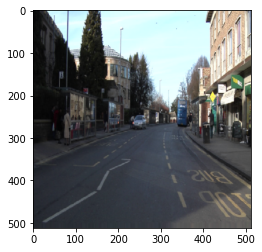

In [63]:
plt.imshow(x)
plt.show()

处理标签数据

In [64]:
y = y[:, :, :, 0] if (len(y.shape) == 4) else y[:, :, 0]
new_label = np.zeros(y.shape + (num_class,))
for i in range(num_class):
    new_label[y == i, i] = 1
print(y.shape)
print(y[0][0])

(512, 512)
5.0


In [65]:
one = [128, 128, 128]
two = [128, 0, 0]
three = [192, 192, 128]
four = [255, 69, 0]
five = [128, 64, 128]
six = [60, 40, 222]
seven = [128, 128, 0]
eight = [192, 128, 128]
nine = [64, 64, 128]
ten = [64, 0, 128]
eleven = [64, 64, 0]
twelve = [0, 128, 192]
COLOR_DICT = np.array([one, two,three,four,five,six,seven,eight,nine,ten,eleven,twelve])

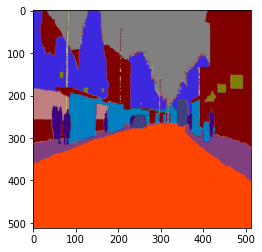

In [66]:
y_ = np.empty([512,512,3], dtype = int)
for i in range(512):
    for j in range(512):
        y_[i][j] = COLOR_DICT[int(y[i][j])]
plt.imshow(y_)
plt.show()